In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
import quandl
import datetime

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

quandl.ApiConfig.api_key = "eRvW6fEn_RcPcsJVjuNp"

amzn = quandl.get('WIKI/AMZN', qopts={'columns': ['Date']})
amzn = amzn.reset_index()
amzn['Date'] = pd.to_datetime(amzn['Date'],format='%Y-%m-%d')
amzn = amzn.set_index('Date') 

In [21]:
# Get competitor data for the same date range
start = amzn.first_valid_index()
end = amzn.last_valid_index()
wmt = quandl.get('WIKI/WMT', qopts={'columns': ['Date']})
wmt = wmt.reset_index()
wmt['Date'] = pd.to_datetime(wmt['Date'],format='%Y-%m-%d')
wmt = wmt.loc[wmt['Date']>=start]
wmt = wmt.loc[wmt['Date']<=end]
wmt.rename(columns={'Volume':'WMT Volume'}, inplace=True)
# Get 5 day moving average
wmt['WMT Moving Avg.'] = wmt.loc[:,'Adj. Close'].rolling(window=5).mean()
#wmt_ma = wmt.loc[:,['Date','WMT Moving Avg.', 'WMT Volume']]
wmt_ma = wmt.loc[:,['Date','WMT Moving Avg.']]

In [22]:
# Merge competitor data
amzn = pd.merge(amzn, wmt_ma, on='Date')
amzn = amzn.set_index('Date')
df = amzn.loc[:,['Adj. Close', 'Volume', 'WMT Moving Avg.']]

# Get 5 day moving average
df['Moving Avg.'] = amzn.loc[:,'Adj. Close'].rolling(window=5).mean()
df.head()

,Adj. Close,Volume,WMT Moving Avg.,Moving Avg.
Date,,,,
1997-05-16,1.729167,1225000.0,NaN,NaN
1997-05-19,1.708333,508900.0,NaN,NaN
1997-05-20,1.635833,455600.0,NaN,NaN
1997-05-21,1.427500,1571100.0,NaN,NaN
1997-05-22,1.395833,981400.0,10.823585,1.579333


In [23]:
# Backfill missing values
df.fillna(method='bfill', inplace=True)

# Separating 10 records to predict.
df['Pred. Close'] = df['Adj. Close'].shift(-10)
x = np.array(df.drop(['Pred. Close'], 1))
x_predict = x[-10:]
x = x[:-10]
y = np.array(df['Pred. Close'])
y = y[:-10]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.002, random_state=100)

# Linear regression
lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)

conf_score = lin_reg.score(x_test, y_test)
print('Confidence Score is ', conf_score)

Confidence Score is  0.9976514215175295


In [24]:
predicted_values = lin_reg.predict(x_predict)
df['Forecast'] = np.nan

In [25]:
last_date = df.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in predicted_values:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]



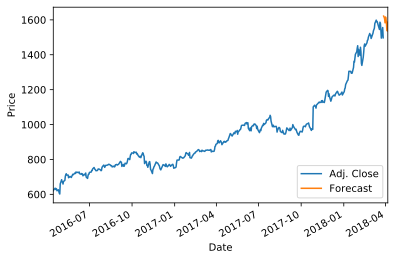

In [26]:
df['Adj. Close'].tail(500).plot()
df['Forecast'].tail(500).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Printing data frame of WIKI/AMZN...
               Open     High      Low    Close     Volume  Ex-Dividend  \
Date                                                                     
1997-05-16    22.38    23.75    20.50    20.75  1225000.0          0.0   
1997-05-19    20.50    21.25    19.50    20.50   508900.0          0.0   
1997-05-20    20.75    21.00    19.63    19.63   455600.0          0.0   
1997-05-21    19.25    19.75    16.50    17.13  1571100.0          0.0   
1997-05-22    17.25    17.38    15.75    16.75   981400.0          0.0   
...             ...      ...      ...      ...        ...          ...   
2018-03-21  1586.45  1590.00  1563.17  1581.86  4667291.0          0.0   
2018-03-22  1565.47  1573.85  1542.40  1544.10  6177737.0          0.0   
2018-03-23  1539.01  1549.02  1495.36  1495.56  7843966.0          0.0   
2018-03-26  1530.00  1556.99  1499.25  1555.86  5547618.0          0.0   
2018-03-27  1572.40  1575.96  1482.32  1497.05  6793279.0          0.0   

 

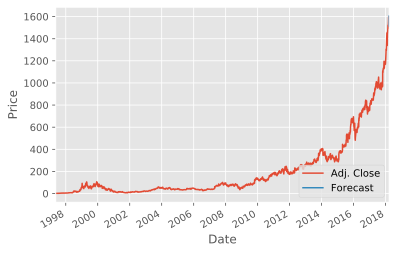

In [27]:
import quandl as Quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, model_selection as cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
import datetime

style.use('ggplot')

#Use Pandas to populate the data frame
df = Quandl.get("WIKI/AMZN",api_key='yN6gWxePyMHXXqxC-xb7')
print("Printing data frame of WIKI/AMZN...")
print(df)
print("End")
df = df[['Adj. Open',  'Adj. High',  'Adj. Low',  'Adj. Close', 'Adj. Volume', 'Ex-Dividend']]
#Calculate percentages
print("Printing Adj only...")
print(df)
print("End")
df['HL_PCT'] = ((df['Adj. High'] - df['Adj. Low']) / df['Adj. Low']) * 100.0
df['PCT_change'] = ((df['Adj. Close'] - df['Adj. Open']) / df['Adj. Close']) * 100.0

#Predict closing values
df = df[['Adj. Close', 'HL_PCT', 'PCT_change', 'Adj. Volume', 'Ex-Dividend']]
forecast_col = 'Adj. Close'

#Replace any NAN so that data is not lost
df.fillna(method="ffill", inplace=True)
df.fillna(method="bfill", inplace=True)
df.fillna(value=0, inplace=True)
forecast_out = int(math.ceil(0.001 * len(df)))
df['label'] = df[forecast_col].shift(-forecast_out)

# X is the input data and excludes labels to be predicted
X = np.array(df.drop(['label'], 1))
#Preprocessing gets values between -1 and 1
X = preprocessing.scale(X)
#Input for which prediction is needed
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

df.dropna(inplace=True)

#Output to be predicted
y = np.array(df['label'])

#Use linear regression classifier
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.2)
clf = LinearRegression(n_jobs=-1)
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print('Confidence:', confidence)

#Predict for the forecast set
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan
#Predict for every day after the last day in training set
last_date = df.iloc[-1].name
last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]
#Plot the graph for visualizayion
df['Adj. Close'].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

#Store the model
import pickle
with open('linearregression.pickle','wb') as f:
    pickle.dump(clf, f)